In [1]:
import sys
import os
import pandas as pd
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [2]:
%load_ext autoreload
%autoreload 2
from data.api_fetcher import ApiFetcher

In [3]:
api = ApiFetcher(starting_year=2019, ending_year=2025)
 

In [7]:
df_p = api.get_dataframe('playerstats', all=True)

In [8]:
df_g = api.get_dataframe('leaguegamelog', all=True)

In [9]:
print(df_g.columns)

Index(['game_id', 'date', 'home_team', 'away_team', 'home_season_id',
       'home_team_id', 'home_team_abbreviation', 'home_wl', 'home_min',
       'home_fgm', 'home_fga', 'home_fg_pct', 'home_fg3m', 'home_fg3a',
       'home_fg3_pct', 'home_ftm', 'home_fta', 'home_ft_pct', 'home_oreb',
       'home_dreb', 'home_reb', 'home_ast', 'home_stl', 'home_blk', 'home_tov',
       'home_pf', 'home_pts', 'home_plus_minus', 'home_video_available',
       'away_season_id', 'away_team_id', 'away_team_abbreviation', 'away_wl',
       'away_min', 'away_fgm', 'away_fga', 'away_fg_pct', 'away_fg3m',
       'away_fg3a', 'away_fg3_pct', 'away_ftm', 'away_fta', 'away_ft_pct',
       'away_oreb', 'away_dreb', 'away_reb', 'away_ast', 'away_stl',
       'away_blk', 'away_tov', 'away_pf', 'away_pts', 'away_plus_minus',
       'away_video_available'],
      dtype='object')


In [10]:
df_g['date'] = pd.to_datetime(df_g['date'])
df_p['game_date'] = pd.to_datetime(df_p['game_date'])


df_g = df_g.sort_values('date').reset_index(drop=True)


In [ ]:


# Create season column
# NBA seasons span two years (e.g., 2024-25 season starts in Oct 2024)
df_g['season'] = df_g['date'].apply(lambda x: x.year if x.month >= 10 else x.year - 1)

# Or if you want the format "22024":
df_g['season'] = df_g['date'].apply(lambda x: 
    int(f"2{x.year}" if x.month >= 10 else f"2{x.year-1}"))

In [12]:
# ============================================================
# STEP 2: BUILD ELO SYSTEM CLASS (AUTO SEASON BASELINE)
# ============================================================
from collections import defaultdict
import numpy as np

class ELOSystem:
    def __init__(self, k_factor=20, initial_rating=1500):
        self.k_factor = k_factor
        self.initial_rating = initial_rating
        
        self.offensive_elo = defaultdict(lambda: initial_rating)
        self.defensive_elo = defaultdict(lambda: initial_rating)
        
        self.season_totals = defaultdict(list)  
        
        self.season_baselines = {}

        self.history = []
    
    def _get_key(self, team_id, season):
        return f"{season}_{team_id}"
    
    def get_offensive_rating(self, team_id, season):
        key = self._get_key(team_id, season)
        return self.offensive_elo[key]
    
    def get_defensive_rating(self, team_id, season):

        key = self._get_key(team_id, season)
        return self.defensive_elo[key]
    
    def get_baseline(self, season, up_to_game_index=None):
        """
        Get season baseline (average total points per team), using only past games.

        Logic:
        - For the first 10 games of a new season, use the previous season's baseline (if available).
        - After that, use the current season's observed games only (no leakage).
        - If no past data exists at all, fall back to a default value (110.0).
        """
        # Fallback if no data at all
        if season not in self.season_totals and (season - 1) not in self.season_totals:
            return 110.0

        # Games observed so far in current season
        current_games = self.season_totals.get(season, [])
        if up_to_game_index is not None:
            current_games = current_games[:up_to_game_index]

        num_games = len(current_games)

        # --- CASE 1: Early in a new season (fewer than 10 games) ---
        if num_games < 10:
            prev_season_games = self.season_totals.get(season - 1, [])
            if len(prev_season_games) >= 10:  # Require some stability
                prev_baseline = np.mean(prev_season_games) / 2
                return prev_baseline
            else:
                return 110.0  # Not enough prior data

        # --- CASE 2: Enough games in current season ---
        season_avg_total = np.mean(current_games)
        baseline_per_team = season_avg_total / 2

        return baseline_per_team

    
    def predict_score(self, team_off_elo, opponent_def_elo, season):
        """
        Predict points based on ELO matchup
        
        Args:
            team_off_elo: Team's offensive ELO
            opponent_def_elo: Opponent's defensive ELO
            season: Season year (for season-specific baseline)
        
        Returns:
            Expected points scored
        """
        # Get season-specific baseline (only uses past games!)
        baseline = self.get_baseline(season)
        
        scale = 25  # Every 25 ELO = 1 point difference
        
        expected = baseline + (team_off_elo - opponent_def_elo) / scale
        return expected
    
    def update_game(self, season, home_id, away_id, home_score, away_score, date):
        """
        Update ELO ratings after observing game result
        
        Process:
        1. Get current ratings
        2. Predict scores using season baseline (from past games only)
        3. Compare to actual result
        4. Update ratings
        5. Add this game to season totals (for future baseline calculations)
        """
        home_key = self._get_key(home_id, season)
        away_key = self._get_key(away_id, season)
        
        # Current ratings
        home_off = self.offensive_elo[home_key]
        home_def = self.defensive_elo[home_key]
        away_off = self.offensive_elo[away_key]
        away_def = self.defensive_elo[away_key]
        
        # Predict expected scores (uses baseline from past games only)
        expected_home = self.predict_score(home_off, away_def, season)
        expected_away = self.predict_score(away_off, home_def, season)
        
        # Calculate errors
        home_off_error = home_score - expected_home
        away_off_error = away_score - expected_away
        home_def_error = away_score - expected_away
        away_def_error = home_score - expected_home
        
        # Update offensive ratings
        self.offensive_elo[home_key] = home_off + self.k_factor * (home_off_error / 10)
        self.offensive_elo[away_key] = away_off + self.k_factor * (away_off_error / 10)
        
        # Update defensive ratings
        self.defensive_elo[home_key] = home_def - self.k_factor * (home_def_error / 10)
        self.defensive_elo[away_key] = away_def - self.k_factor * (away_def_error / 10)
        
        # Add this game to season totals (AFTER prediction, so no leakage)
        total_score = home_score + away_score
        self.season_totals[season].append(total_score)
        
        # Record history
        self.history.append({
            'date': date,
            'season': season,
            'home_team': home_id,
            'away_team': away_id,
            'home_off_elo': self.offensive_elo[home_key],
            'home_def_elo': self.defensive_elo[home_key],
            'away_off_elo': self.offensive_elo[away_key],
            'away_def_elo': self.defensive_elo[away_key],
            'home_score': home_score,
            'away_score': away_score,
            'expected_home': expected_home,
            'expected_away': expected_away,
            'total_score': total_score,
            'expected_total': expected_home + expected_away,
            'total_error': total_score - (expected_home + expected_away),
            'baseline_used': self.get_baseline(season),
            'season_games_so_far': len(self.season_totals[season])
        })
    
    def predict(self, home_id, away_id, season):
        """
        Predict game scores based on current ELO ratings
        
        Args:
            home_id: Home team ID
            away_id: Away team ID
            season: Season year
        
        Returns:
            dict with home_score, away_score, total_score, and metadata
        """
        home_off = self.get_offensive_rating(home_id, season)
        home_def = self.get_defensive_rating(home_id, season)
        away_off = self.get_offensive_rating(away_id, season)
        away_def = self.get_defensive_rating(away_id, season)
        
        # Predict scores (uses season-specific baseline)
        home_score = self.predict_score(home_off, away_def, season)
        away_score = self.predict_score(away_off, home_def, season)
        
        # Home court advantage
        home_score += 2.0
        
        return {
            'home_score': home_score,
            'away_score': away_score,
            'total_score': home_score + away_score,
            'home_off_elo': home_off,
            'home_def_elo': home_def,
            'away_off_elo': away_off,
            'away_def_elo': away_def,
            'season': season,
            'baseline': self.get_baseline(season),
            'season_games': len(self.season_totals.get(season, []))
        }
    
    def get_season_summary(self):
        """
        Get summary of all seasons processed
        
        Returns:
            DataFrame with season statistics
        """
        import pandas as pd
        
        summary = []
        for season in sorted(self.season_totals.keys()):
            totals = self.season_totals[season]
            summary.append({
                'season': season,
                'games': len(totals),
                'avg_total': np.mean(totals),
                'baseline_per_team': np.mean(totals) / 2,
                'std_dev': np.std(totals),
                'min_total': np.min(totals),
                'max_total': np.max(totals)
            })
        
        return pd.DataFrame(summary)

In [13]:
# Step 1: Create ELO system
elo = ELOSystem(k_factor=20, initial_rating=1500)

# Step 2: Process historical games to build up ratings
print(f"\n📈 Processing {len(df_g)} historical games...")
for _, row in df_g.iterrows():
    elo.update_game(
        season=row['season'],
        home_id=row['home_team_id'],
        away_id=row['away_team_id'],
        home_score=row['home_pts'],
        away_score=row['away_pts'],
        date=row['date']
    )

print("✅ Processing complete!")


📈 Processing 7054 historical games...


KeyError: 'season'

In [66]:
# ============================================================
# STEP 3: TEST ON FIRST 10 GAMES
# ============================================================

# Create ELO system
elo = ELOSystem(k_factor=20)

print("🧪 Testing on first 10 games:\n")

for idx in range(10):
    game = df_g.iloc[idx]
    
    # Predict (using current ratings)
    pred = elo.predict(
        game['home_team_id'], 
        game['away_team_id'], 
        game['home_season_id']
    )
    
    print(f"Game {idx+1}: {game['away_team']} @ {game['home_team']}")
    print(f"   Predicted: {pred['home_score']:.1f} - {pred['away_score']:.1f}")
    print(f"   Actual:    {game['home_pts']} - {game['away_pts']}")
    print(f"   Error:     {abs(pred['home_score'] - game['home_pts']):.1f}, "
          f"{abs(pred['away_score'] - game['away_pts']):.1f}")
    
    # Update ratings after observing result
    elo.update_game(
        game['home_season_id'],
        game['home_team_id'],
        game['away_team_id'],
        game['home_pts'],
        game['away_pts'],
        game['date']
    )
    print()

✅ ELO System initialized (auto season baseline)
   K-factor: 20
   Initial rating: 1500
   ✨ Automatic baseline per season (no leakage)
🧪 Testing on first 10 games:

Game 1: Los Angeles Lakers @ LA Clippers
   Predicted: 112.0 - 110.0
   Actual:    112 - 102
   Error:     0.0, 8.0

Game 2: New Orleans Pelicans @ Toronto Raptors
   Predicted: 112.0 - 110.0
   Actual:    130 - 122
   Error:     18.0, 12.0

Game 3: Sacramento Kings @ Phoenix Suns
   Predicted: 112.0 - 110.0
   Actual:    124 - 95
   Error:     12.0, 15.0

Game 4: Oklahoma City Thunder @ Utah Jazz
   Predicted: 112.0 - 110.0
   Actual:    100 - 95
   Error:     12.0, 15.0

Game 5: Boston Celtics @ Philadelphia 76ers
   Predicted: 112.0 - 110.0
   Actual:    107 - 93
   Error:     5.0, 17.0

Game 6: Chicago Bulls @ Charlotte Hornets
   Predicted: 112.0 - 110.0
   Actual:    126 - 125
   Error:     14.0, 15.0

Game 7: Washington Wizards @ Dallas Mavericks
   Predicted: 112.0 - 110.0
   Actual:    108 - 100
   Error:     4.0,

In [67]:
class ELOSystem:
    """ELO with NO DATA LEAKAGE"""
    
    def __init__(self, k_factor=20, initial_rating=1500):
        self.k_factor = k_factor
        self.initial_rating = initial_rating
        self.offensive_elo = defaultdict(lambda: initial_rating)
        self.defensive_elo = defaultdict(lambda: initial_rating)
        self.history = []
        
        # Track actual scores to calculate rolling baseline
        self.observed_totals = []
        
        print(f"✅ ELO System initialized (no leakage)")
        print(f"   K-factor: {k_factor}")
        print(f"   Rolling baseline (updates as games played)")
    
    def _get_key(self, team_id, season):
        return f"{season}_{team_id}"
    
    def get_offensive_rating(self, team_id, season):
        key = self._get_key(team_id, season)
        return self.offensive_elo[key]
    
    def get_defensive_rating(self, team_id, season):
        key = self._get_key(team_id, season)
        return self.defensive_elo[key]
    
    def get_baseline(self):
        """
        Calculate baseline from games observed SO FAR
        No future information!
        """
        if len(self.observed_totals) < 50:
            # Not enough data yet, use league-wide default
            return 110.0
        else:
            # Use average of observed games (no leakage!)
            return np.mean(self.observed_totals) / 2
    
    def predict_score(self, team_off_elo, opponent_def_elo):
        """Predict with rolling baseline (no future info)"""
        baseline = self.get_baseline()  # Only uses past games!
        scale = 25
        expected = baseline + (team_off_elo - opponent_def_elo) / scale
        return expected
    
    def update_game(self, season, home_id, away_id, home_score, away_score, date):
        home_key = self._get_key(home_id, season)
        away_key = self._get_key(away_id, season)
        
        home_off = self.offensive_elo[home_key]
        home_def = self.defensive_elo[home_key]
        away_off = self.offensive_elo[away_key]
        away_def = self.defensive_elo[away_key]
        
        expected_home = self.predict_score(home_off, away_def)
        expected_away = self.predict_score(away_off, home_def)
        
        home_off_error = home_score - expected_home
        away_off_error = away_score - expected_away
        home_def_error = away_score - expected_away
        away_def_error = home_score - expected_home
        
        self.offensive_elo[home_key] = home_off + self.k_factor * (home_off_error / 10)
        self.offensive_elo[away_key] = away_off + self.k_factor * (away_off_error / 10)
        self.defensive_elo[home_key] = home_def - self.k_factor * (home_def_error / 10)
        self.defensive_elo[away_key] = away_def - self.k_factor * (away_def_error / 10)
        
        # AFTER prediction, add this game to observed totals
        self.observed_totals.append(home_score + away_score)
        
        self.history.append({
            'date': date,
            'home_team': home_id,
            'away_team': away_id,
            'home_off_elo': self.offensive_elo[home_key],
            'home_def_elo': self.defensive_elo[home_key],
            'away_off_elo': self.offensive_elo[away_key],
            'away_def_elo': self.defensive_elo[away_key],
            'home_score': home_score,
            'away_score': away_score,
            'expected_home': expected_home,
            'expected_away': expected_away,
            'total_score': home_score + away_score,
            'expected_total': expected_home + expected_away,
            'total_error': (home_score + away_score) - (expected_home + expected_away),
            'baseline_used': self.get_baseline()
        })
    
    def predict(self, home_id, away_id, season):
        home_off = self.get_offensive_rating(home_id, season)
        home_def = self.get_defensive_rating(home_id, season)
        away_off = self.get_offensive_rating(away_id, season)
        away_def = self.get_defensive_rating(away_id, season)
        
        home_score = self.predict_score(home_off, away_def)
        away_score = self.predict_score(away_off, home_def)
        
        home_score += 2.0
        
        return {
            'home_score': home_score,
            'away_score': away_score,
            'total_score': home_score + away_score,
            'home_off_elo': home_off,
            'home_def_elo': home_def,
            'away_off_elo': away_off,
            'away_def_elo': away_def
        }

print("✅ ELOSystem class defined (no data leakage)")

✅ ELOSystem class defined (no data leakage)


In [19]:
from collections import defaultdict
import numpy as np
from datetime import datetime

class ELOSystem:
    """
    Modular ELO System - Toggle features on/off easily
    
    Features you can enable/disable:
    - home_court_advantage: Add points for home team
    - rest_days: Adjust for back-to-backs
    - momentum: Weight recent games more
    - regression_to_mean: Ratings drift back to 1500
    """
    
    def __init__(self, 
                 k_factor=20, 
                 initial_rating=1500,
                 # Feature toggles
                 use_home_court=True,
                 use_rest_days=False,
                 use_momentum=False,
                 use_regression=False,
                 # Feature parameters
                 home_court_advantage=2.0,
                 rest_impact=2.0,
                 momentum_weight=0.3,
                 regression_rate=0.005):
        """
        Initialize ELO system with toggleable features
        
        Args:
            k_factor: Base learning rate (20 = moderate)
            initial_rating: Starting rating (1500 = average)
            
            Feature toggles:
            use_home_court: Apply home court advantage
            use_rest_days: Adjust for rest days
            use_momentum: Weight recent performance
            use_regression: Drift ratings toward mean
            
            Feature parameters:
            home_court_advantage: Points added to home team (default 2.0)
            rest_impact: Points per day of rest difference (default 2.0)
            momentum_weight: How much to weight last 5 games (0-1, default 0.3)
            regression_rate: How fast ratings drift to mean (default 0.005)
        """
        self.k_factor = k_factor
        self.initial_rating = initial_rating
        
        # Feature toggles
        self.use_home_court = use_home_court
        self.use_rest_days = use_rest_days
        self.use_momentum = use_momentum
        self.use_regression = use_regression
        
        # Feature parameters
        self.home_court_advantage = home_court_advantage
        self.rest_impact = rest_impact
        self.momentum_weight = momentum_weight
        self.regression_rate = regression_rate
        
        # Core data structures
        self.offensive_elo = defaultdict(lambda: initial_rating)
        self.defensive_elo = defaultdict(lambda: initial_rating)
        self.history = []
        self.observed_totals = []
        self.season_totals = defaultdict(list)
        
        # Rest days tracking
        self.last_game_date = {}
        
        # Momentum tracking (recent game performance)
        self.recent_performance = defaultdict(list)  # {team_key: [error1, error2, ...]}
        
        # Statistics
        self.rest_adjustments = 0
        self.momentum_adjustments = 0
        
        print(f"✅ ELO System initialized (no leakage)")
        print(f"   K-factor: {k_factor}")
        print(f"   Initial rating: {initial_rating}")
        print(f"\n🎛️ FEATURES ENABLED:")
        print(f"   {'✅' if use_home_court else '❌'} Home court advantage: {home_court_advantage if use_home_court else 'OFF'}")
        print(f"   {'✅' if use_rest_days else '❌'} Rest days adjustment: {rest_impact if use_rest_days else 'OFF'}")
        print(f"   {'✅' if use_momentum else '❌'} Momentum/form: {momentum_weight if use_momentum else 'OFF'}")
        print(f"   {'✅' if use_regression else '❌'} Regression to mean: {regression_rate if use_regression else 'OFF'}")
    
    def _get_key(self, team_id, season):
        """Create unique key for team-season"""
        return f"{season}_{team_id}"
    
    def get_offensive_rating(self, team_id, season):
        """Get team's offensive ELO"""
        key = self._get_key(team_id, season)
        return self.offensive_elo[key]
    
    def get_defensive_rating(self, team_id, season):
        """Get team's defensive ELO"""
        key = self._get_key(team_id, season)
        return self.defensive_elo[key]
    
    def get_baseline(self):
        """
        Calculate baseline without resetting between seasons.

        Rules:
        1. If no games observed → fallback 110.0
        2. If fewer than 10 games observed → use previous season's average (last season's data)
        3. Otherwise → use current season's data (games observed so far)

        Assumes self.season_totals is {season: [total_scores]}, and seasons are processed in order.
        """
        # Case 1: No data at all
        if not self.season_totals:
            return 110.0

        # Identify the most recent season
        seasons = sorted(self.season_totals.keys())
        current_season = seasons[-1]
        current_games = self.season_totals[current_season]

        # Case 2: Fewer than 10 games in current season → use previous season
        if len(current_games) < 10:
            if len(seasons) > 1:
                prev_season = seasons[-2]
                prev_games = self.season_totals[prev_season]
                if len(prev_games) > 0:
                    return np.mean(prev_games) / 2
            return 110.0  # no previous data → fallback

        # Case 3: Normal case → current season average (no leakage)
        return np.mean(current_games) / 2


    # ============================================================
    # FEATURE 1: HOME COURT ADVANTAGE
    # ============================================================
    def apply_home_court_advantage(self, home_score, away_score):
        """
        Add home court advantage to home team prediction
        
        Returns:
            (adjusted_home_score, adjusted_away_score)
        """
        if not self.use_home_court:
            return home_score, away_score
        
        home_score += self.home_court_advantage
        return home_score, away_score
    
    # ============================================================
    # FEATURE 2: REST DAYS ADJUSTMENT
    # ============================================================
    def get_rest_days(self, team_id, season, current_date):
        """Calculate days of rest since last game"""
        if not self.use_rest_days:
            return 1  # Default
        
        key = self._get_key(team_id, season)
        
        if key not in self.last_game_date:
            return 3  # First game, assume well-rested
        
        # Convert to datetime if string
        if isinstance(current_date, str):
            current_date = datetime.strptime(current_date, '%Y-%m-%d')
        
        last_date = self.last_game_date[key]
        if isinstance(last_date, str):
            last_date = datetime.strptime(last_date, '%Y-%m-%d')
        
        days_rest = (current_date - last_date).days - 1
        return max(0, days_rest)
    
    def apply_rest_adjustment(self, home_score, away_score, home_rest, away_rest):
        """
        Adjust scores based on rest difference
        
        Returns:
            (adjusted_home_score, adjusted_away_score, adjustment_value)
        """
        if not self.use_rest_days:
            return home_score, away_score, 0.0
        
        rest_diff = home_rest - away_rest
        rest_diff = max(-3, min(3, rest_diff))  # Cap at ±3 days
        
        adjustment = rest_diff * self.rest_impact
        
        if adjustment != 0:
            self.rest_adjustments += 1
        
        return home_score + adjustment, away_score - adjustment, adjustment
    
    def update_rest_tracking(self, team_id, season, date):
        """Update last game date for team"""
        if self.use_rest_days:
            key = self._get_key(team_id, season)
            self.last_game_date[key] = date
    
    # ============================================================
    # FEATURE 3: MOMENTUM/FORM
    # ============================================================
    def get_momentum_adjustment(self, team_key):
        """
        Calculate momentum boost based on recent performance
        
        Returns:
            Points to add (positive = hot streak, negative = cold)
        """
        if not self.use_momentum:
            return 0.0
        
        if team_key not in self.recent_performance:
            return 0.0
        
        recent = self.recent_performance[team_key][-5:]  # Last 5 games
        
        if len(recent) < 3:
            return 0.0
        
        # Average performance vs expectation
        avg_error = np.mean(recent)
        
        # Scale by momentum weight
        adjustment = avg_error * self.momentum_weight
        
        if abs(adjustment) > 0.1:
            self.momentum_adjustments += 1
        
        return adjustment
    
    def update_momentum_tracking(self, team_key, error):
        """Track recent performance for momentum"""
        if self.use_momentum:
            self.recent_performance[team_key].append(error)
            # Keep only last 10 games
            if len(self.recent_performance[team_key]) > 10:
                self.recent_performance[team_key].pop(0)
    
    # ============================================================
    # FEATURE 4: REGRESSION TO MEAN
    # ============================================================
    def apply_regression_to_mean(self, team_key):
        """
        Drift ratings back toward initial rating over time
        """
        if not self.use_regression:
            return
        
        # Offensive rating regression
        current_off = self.offensive_elo[team_key]
        self.offensive_elo[team_key] = (
            current_off + (self.initial_rating - current_off) * self.regression_rate
        )
        
        # Defensive rating regression
        current_def = self.defensive_elo[team_key]
        self.defensive_elo[team_key] = (
            current_def + (self.initial_rating - current_def) * self.regression_rate
        )
    
    # ============================================================
    # CORE ELO METHODS
    # ============================================================
    
    def predict_score(self, team_off_elo, opponent_def_elo):
        """Predict with rolling baseline (no future info)"""
        baseline = self.get_baseline()
        scale = 25
        expected = baseline + (team_off_elo - opponent_def_elo) / scale
        return expected
    
    def update_game(self, season, home_id, away_id, home_score, away_score, date):
        """
        Update ELO ratings after game (applies all enabled features)
        """
        home_key = self._get_key(home_id, season)
        away_key = self._get_key(away_id, season)
        
        # Get current ratings
        home_off = self.offensive_elo[home_key]
        home_def = self.defensive_elo[home_key]
        away_off = self.offensive_elo[away_key]
        away_def = self.defensive_elo[away_key]
        
        # Base prediction (no features yet)
        expected_home = self.predict_score(home_off, away_def)
        expected_away = self.predict_score(away_off, home_def)
        
        # FEATURE 1: Home court advantage
        expected_home, expected_away = self.apply_home_court_advantage(
            expected_home, expected_away
        )
        
        # FEATURE 2: Rest days
        home_rest = self.get_rest_days(home_id, season, date)
        away_rest = self.get_rest_days(away_id, season, date)
        expected_home, expected_away, rest_adj = self.apply_rest_adjustment(
            expected_home, expected_away, home_rest, away_rest
        )
        
        # FEATURE 3: Momentum
        home_momentum = self.get_momentum_adjustment(home_key)
        away_momentum = self.get_momentum_adjustment(away_key)
        expected_home += home_momentum
        expected_away += away_momentum
        
        # Calculate errors
        home_off_error = home_score - expected_home
        away_off_error = away_score - expected_away
        home_def_error = away_score - expected_away
        away_def_error = home_score - expected_home
        
        # Update ratings
        self.offensive_elo[home_key] = home_off + self.k_factor * (home_off_error / 10)
        self.offensive_elo[away_key] = away_off + self.k_factor * (away_off_error / 10)
        self.defensive_elo[home_key] = home_def - self.k_factor * (home_def_error / 10)
        self.defensive_elo[away_key] = away_def - self.k_factor * (away_def_error / 10)
        
        # FEATURE 4: Regression to mean
        self.apply_regression_to_mean(home_key)
        self.apply_regression_to_mean(away_key)
        
        # Update tracking (AFTER prediction to avoid leakage)
                # Update tracking (AFTER prediction to avoid leakage)
        total = home_score + away_score
        self.observed_totals.append(total)
        self.season_totals[season].append(total)  # ADD THIS LINE
        self.update_rest_tracking(home_id, season, date)
        self.update_rest_tracking(away_id, season, date)
        self.update_momentum_tracking(home_key, home_off_error)
        self.update_momentum_tracking(away_key, away_off_error)
        
        # Record history
        self.history.append({
            'date': date,
            'home_team': home_id,
            'away_team': away_id,
            'home_off_elo': self.offensive_elo[home_key],
            'home_def_elo': self.defensive_elo[home_key],
            'away_off_elo': self.offensive_elo[away_key],
            'away_def_elo': self.defensive_elo[away_key],
            'home_score': home_score,
            'away_score': away_score,
            'expected_home': expected_home,
            'expected_away': expected_away,
            'total_score': home_score + away_score,
            'expected_total': expected_home + expected_away,
            'total_error': (home_score + away_score) - (expected_home + expected_away),
            'baseline_used': self.get_baseline(),
            'home_rest_days': home_rest if self.use_rest_days else None,
            'away_rest_days': away_rest if self.use_rest_days else None,
            'rest_adjustment': rest_adj if self.use_rest_days else None,
            'home_momentum': home_momentum if self.use_momentum else None,
            'away_momentum': away_momentum if self.use_momentum else None
        })
    
    def predict(self, home_id, away_id, season, date=None):
        """
        Predict game scores (applies all enabled features)
        """
        home_key = self._get_key(home_id, season)
        away_key = self._get_key(away_id, season)
        
        home_off = self.offensive_elo[home_key]
        home_def = self.defensive_elo[home_key]
        away_off = self.offensive_elo[away_key]
        away_def = self.defensive_elo[away_key]
        
        # Base prediction
        home_score = self.predict_score(home_off, away_def)
        away_score = self.predict_score(away_off, home_def)
        
        # FEATURE 1: Home court advantage
        home_score, away_score = self.apply_home_court_advantage(home_score, away_score)
        
        # FEATURE 2: Rest days
        if date:
            home_rest = self.get_rest_days(home_id, season, date)
            away_rest = self.get_rest_days(away_id, season, date)
            home_score, away_score, _ = self.apply_rest_adjustment(
                home_score, away_score, home_rest, away_rest
            )
        
        # FEATURE 3: Momentum
        home_momentum = self.get_momentum_adjustment(home_key)
        away_momentum = self.get_momentum_adjustment(away_key)
        home_score += home_momentum
        away_score += away_momentum
        
        return {
            'home_score': home_score,
            'away_score': away_score,
            'total_score': home_score + away_score,
            'home_off_elo': home_off,
            'home_def_elo': home_def,
            'away_off_elo': away_off,
            'away_def_elo': away_def
        }
    
    def get_feature_stats(self):
        """Print statistics about feature usage"""
        print("\n" + "="*60)
        print("📊 FEATURE USAGE STATISTICS")
        print("="*60)
        print(f"Total games processed: {len(self.history)}")
        
        if self.use_rest_days:
            pct = (self.rest_adjustments / len(self.history)) * 100
            print(f"✅ Rest adjustments applied: {self.rest_adjustments} ({pct:.1f}%)")
        else:
            print(f"❌ Rest days feature: OFF")
        
        if self.use_momentum:
            pct = (self.momentum_adjustments / len(self.history)) * 100
            print(f"✅ Momentum adjustments applied: {self.momentum_adjustments} ({pct:.1f}%)")
        else:
            print(f"❌ Momentum feature: OFF")
        
        if self.use_home_court:
            print(f"✅ Home court advantage: {self.home_court_advantage} pts")
        else:
            print(f"❌ Home court advantage: OFF")
        
        if self.use_regression:
            print(f"✅ Regression to mean: {self.regression_rate} rate")
        else:
            print(f"❌ Regression to mean: OFF")

print("✅ Modular ELOSystem class defined")
print("\n💡 USAGE EXAMPLES:")
print("# Baseline (no features):")
print("elo = ELOSystem(use_home_court=False, use_rest_days=False)")
print("\n# Just home court:")
print("elo = ELOSystem(use_home_court=True, home_court_advantage=2.5)")
print("\n# All features:")
print("elo = ELOSystem(use_home_court=True, use_rest_days=True, use_momentum=True)")

✅ Modular ELOSystem class defined

💡 USAGE EXAMPLES:
# Baseline (no features):
elo = ELOSystem(use_home_court=False, use_rest_days=False)

# Just home court:
elo = ELOSystem(use_home_court=True, home_court_advantage=2.5)

# All features:
elo = ELOSystem(use_home_court=True, use_rest_days=True, use_momentum=True)


In [20]:
# ============================================================
# STEP 4: RUN ON ALL GAMES (WALK-FORWARD VALIDATION)
# ============================================================

print("🚀 Processing all games...\n")

# Reset ELO system
elo = ELOSystem(k_factor=20)

predictions = []
actuals = []

# Process each game chronologically
for idx, game in df_g.iterrows():
    # Skip first 50 games (warmup period)
    if idx >= 50:
        # PREDICT using ratings BEFORE this game
        pred = elo.predict(
            game['home_team_id'],
            game['away_team_id'],
            game['home_season_id']
        )
        
        predictions.append([
            pred['home_score'],
            pred['away_score'],
            pred['total_score']
        ])
        
        actuals.append([
            game['home_pts'],
            game['away_pts'],
            game['home_pts'] + game['away_pts']
        ])
    
    # UPDATE ratings after observing result
    elo.update_game(
        game['home_season_id'],
        game['home_team_id'],
        game['away_team_id'],
        game['home_pts'],
        game['away_pts'],
        game['date']
    )
    
    # Progress
    if (idx + 1) % 200 == 0:
        print(f"   Processed {idx+1} games...")

print(f"\n✅ Processed all {len(df_g)} games")
print(f"   Made predictions for {len(predictions)} games (after warmup)")

🚀 Processing all games...

✅ ELO System initialized (no leakage)
   K-factor: 20
   Initial rating: 1500

🎛️ FEATURES ENABLED:
   ✅ Home court advantage: 2.0
   ❌ Rest days adjustment: OFF
   ❌ Momentum/form: OFF
   ❌ Regression to mean: OFF
   Processed 200 games...
   Processed 400 games...
   Processed 600 games...
   Processed 800 games...
   Processed 1000 games...
   Processed 1200 games...
   Processed 1400 games...
   Processed 1600 games...
   Processed 1800 games...
   Processed 2000 games...
   Processed 2200 games...
   Processed 2400 games...
   Processed 2600 games...
   Processed 2800 games...
   Processed 3000 games...
   Processed 3200 games...
   Processed 3400 games...
   Processed 3600 games...
   Processed 3800 games...
   Processed 4000 games...
   Processed 4200 games...
   Processed 4400 games...
   Processed 4600 games...
   Processed 4800 games...
   Processed 5000 games...
   Processed 5200 games...
   Processed 5400 games...
   Processed 5600 games...
   Pro

In [29]:
# TEST 1: Baseline (no features)
elo = ELOSystem(
    k_factor=20,
    use_home_court=False,
    use_rest_days=False,
    use_momentum=False,
    use_regression=False
)

# TEST 2: Just home court advantage
elo = ELOSystem(
    use_home_court=True,
    home_court_advantage=2.5,  # Try different values
    use_rest_days=False,
    use_momentum=False,
    use_regression=False
)

# TEST 3: Home court + rest days
elo = ELOSystem(
    use_home_court=True,
    use_rest_days=True,
    rest_impact=2.0,
    use_momentum=False,
    use_regression=False
)

# TEST 4: All features
elo = ELOSystem(
    use_home_court=True,
    use_rest_days=True,
    use_momentum=True,
    use_regression=True,
    home_court_advantage=3,
    rest_impact=2.0,
    momentum_weight=0.3,
    regression_rate=0.01
)

# Process games (same code for all tests)
# Process games with your actual columns
for _, row in df_g.iterrows():
    elo.update_game(
        season=row['home_season_id'],  # or away_season_id (should be same)
        home_id=row['home_team_id'],
        away_id=row['away_team_id'],
        home_score=row['home_pts'],
        away_score=row['away_pts'],
        date=row['date']
    )

# Check which features were used
elo.get_feature_stats()

# Check which features were used
elo.get_feature_stats()

✅ ELO System initialized (no leakage)
   K-factor: 20
   Initial rating: 1500

🎛️ FEATURES ENABLED:
   ❌ Home court advantage: OFF
   ❌ Rest days adjustment: OFF
   ❌ Momentum/form: OFF
   ❌ Regression to mean: OFF
✅ ELO System initialized (no leakage)
   K-factor: 20
   Initial rating: 1500

🎛️ FEATURES ENABLED:
   ✅ Home court advantage: 2.5
   ❌ Rest days adjustment: OFF
   ❌ Momentum/form: OFF
   ❌ Regression to mean: OFF
✅ ELO System initialized (no leakage)
   K-factor: 20
   Initial rating: 1500

🎛️ FEATURES ENABLED:
   ✅ Home court advantage: 2.0
   ✅ Rest days adjustment: 2.0
   ❌ Momentum/form: OFF
   ❌ Regression to mean: OFF
✅ ELO System initialized (no leakage)
   K-factor: 20
   Initial rating: 1500

🎛️ FEATURES ENABLED:
   ✅ Home court advantage: 3
   ✅ Rest days adjustment: 2.0
   ✅ Momentum/form: 0.3
   ✅ Regression to mean: 0.01

📊 FEATURE USAGE STATISTICS
Total games processed: 7054
✅ Rest adjustments applied: 3247 (46.0%)
✅ Momentum adjustments applied: 12786 (181.3

In [27]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_elo(elo):
    """
    Calculate MAE, RMSE, and win accuracy for ELO system
    """
    df = pd.DataFrame(elo.history)
    
    if len(df) == 0:
        print("⚠️ No games in history!")
        return
    
    # Score predictions
    home_mae = mean_absolute_error(df['home_score'], df['expected_home'])
    away_mae = mean_absolute_error(df['away_score'], df['expected_away'])
    total_mae = mean_absolute_error(df['total_score'], df['expected_total'])
    total_rmse = np.sqrt(mean_squared_error(df['total_score'], df['expected_total']))
    
    # Win prediction accuracy
    actual_wins = (df['home_score'] > df['away_score']).astype(int)
    predicted_wins = (df['expected_home'] > df['expected_away']).astype(int)
    win_accuracy = (actual_wins == predicted_wins).mean() * 100
    
    # Error distribution
    errors = df['total_error'].abs()
    within_5 = (errors <= 5).mean() * 100
    within_10 = (errors <= 10).mean() * 100
    within_15 = (errors <= 15).mean() * 100
    
    # Bias
    mean_error = df['total_error'].mean()
    std_error = df['total_error'].std()
    
    print("\n" + "="*60)
    print("📊 ELO SYSTEM PERFORMANCE")
    print("="*60)
    print(f"\n🏀 Score Prediction:")
    print(f"   Home MAE: {home_mae:.2f} points")
    print(f"   Away MAE: {away_mae:.2f} points")
    print(f"   Total MAE: {total_mae:.2f} points")
    print(f"   Total RMSE: {total_rmse:.2f} points")
    
    print(f"\n🎯 Win Prediction:")
    print(f"   Accuracy: {win_accuracy:.1f}%")
    
    print(f"\n📈 Error Distribution:")
    print(f"   Within ±5 points: {within_5:.1f}%")
    print(f"   Within ±10 points: {within_10:.1f}%")
    print(f"   Within ±15 points: {within_15:.1f}%")
    
    print(f"\n📊 Prediction Bias:")
    print(f"   Mean error: {mean_error:.2f} (positive = over-predicting)")
    print(f"   Std dev: {std_error:.2f}")
    print("="*60)
    
    return {
        'home_mae': home_mae,
        'away_mae': away_mae,
        'total_mae': total_mae,
        'total_rmse': total_rmse,
        'win_accuracy': win_accuracy
    }

# Now test each configuration
print("\n\n🧪 TEST 1: BASELINE (No features)")
print("="*60)
elo1 = ELOSystem(use_home_court=False, use_rest_days=False, use_momentum=False, use_regression=False)
for _, row in df_g.iterrows():
    elo1.update_game(row['home_season_id'], row['home_team_id'], row['away_team_id'], 
                     row['home_pts'], row['away_pts'], row['date'])
results1 = evaluate_elo(elo1)

print("\n\n🧪 TEST 2: HOME COURT ONLY")
print("="*60)
elo2 = ELOSystem(use_home_court=True, home_court_advantage=2.5, use_rest_days=False, use_momentum=False, use_regression=False)
for _, row in df_g.iterrows():
    elo2.update_game(row['home_season_id'], row['home_team_id'], row['away_team_id'], 
                     row['home_pts'], row['away_pts'], row['date'])
results2 = evaluate_elo(elo2)

print("\n\n🧪 TEST 3: HOME COURT + REST DAYS")
print("="*60)
elo3 = ELOSystem(use_home_court=True, use_rest_days=True, use_momentum=False, use_regression=False)
for _, row in df_g.iterrows():
    elo3.update_game(row['home_season_id'], row['home_team_id'], row['away_team_id'], 
                     row['home_pts'], row['away_pts'], row['date'])
results3 = evaluate_elo(elo3)

print("\n\n🧪 TEST 4: ALL FEATURES")
print("="*60)
elo4 = ELOSystem(use_home_court=True, use_rest_days=True, use_momentum=True, use_regression=True)
for _, row in df_g.iterrows():
    elo4.update_game(row['home_season_id'], row['home_team_id'], row['away_team_id'], 
                     row['home_pts'], row['away_pts'], row['date'])
results4 = evaluate_elo(elo4)

# Compare all
print("\n\n" + "="*60)
print("🏆 FEATURE COMPARISON")
print("="*60)
comparison = pd.DataFrame({
    'Test': ['Baseline', 'Home Court', 'Home+Rest', 'All Features'],
    'Total MAE': [results1['total_mae'], results2['total_mae'], results3['total_mae'], results4['total_mae']],
    'Win Acc %': [results1['win_accuracy'], results2['win_accuracy'], results3['win_accuracy'], results4['win_accuracy']]
})
print(comparison.to_string(index=False))



🧪 TEST 1: BASELINE (No features)
✅ ELO System initialized (no leakage)
   K-factor: 20
   Initial rating: 1500

🎛️ FEATURES ENABLED:
   ❌ Home court advantage: OFF
   ❌ Rest days adjustment: OFF
   ❌ Momentum/form: OFF
   ❌ Regression to mean: OFF

📊 ELO SYSTEM PERFORMANCE

🏀 Score Prediction:
   Home MAE: 9.33 points
   Away MAE: 9.32 points
   Total MAE: 14.83 points
   Total RMSE: 18.71 points

🎯 Win Prediction:
   Accuracy: 62.4%

📈 Error Distribution:
   Within ±5 points: 21.3%
   Within ±10 points: 41.2%
   Within ±15 points: 58.0%

📊 Prediction Bias:
   Mean error: 0.22 (positive = over-predicting)
   Std dev: 18.71


🧪 TEST 2: HOME COURT ONLY
✅ ELO System initialized (no leakage)
   K-factor: 20
   Initial rating: 1500

🎛️ FEATURES ENABLED:
   ✅ Home court advantage: 2.5
   ❌ Rest days adjustment: OFF
   ❌ Momentum/form: OFF
   ❌ Regression to mean: OFF

📊 ELO SYSTEM PERFORMANCE

🏀 Score Prediction:
   Home MAE: 9.31 points
   Away MAE: 9.29 points
   Total MAE: 14.85 points


In [32]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_elo(elo, test_name):
    """
    Calculate MAE, RMSE, and win accuracy for ELO system
    """
    df = pd.DataFrame(elo.history)
    
    if len(df) == 0:
        print("⚠️ No games in history!")
        return None
    
    # Score predictions
    home_mae = mean_absolute_error(df['home_score'], df['expected_home'])
    away_mae = mean_absolute_error(df['away_score'], df['expected_away'])
    total_mae = mean_absolute_error(df['total_score'], df['expected_total'])
    total_rmse = np.sqrt(mean_squared_error(df['total_score'], df['expected_total']))
    
    # Win prediction accuracy
    actual_wins = (df['home_score'] > df['away_score']).astype(int)
    predicted_wins = (df['expected_home'] > df['expected_away']).astype(int)
    win_accuracy = (actual_wins == predicted_wins).mean() * 100
    
    # Error distribution
    errors = df['total_error'].abs()
    within_5 = (errors <= 5).mean() * 100
    within_10 = (errors <= 10).mean() * 100
    within_15 = (errors <= 15).mean() * 100
    
    # Bias
    mean_error = df['total_error'].mean()
    std_error = df['total_error'].std()
    
    print("\n" + "="*60)
    print(f"📊 {test_name}")
    print("="*60)
    print(f"\n🏀 Score Prediction:")
    print(f"   Home MAE: {home_mae:.2f} points")
    print(f"   Away MAE: {away_mae:.2f} points")
    print(f"   Total MAE: {total_mae:.2f} points")
    print(f"   Total RMSE: {total_rmse:.2f} points")
    
    print(f"\n🎯 Win Prediction:")
    print(f"   Accuracy: {win_accuracy:.1f}%")
    
    print(f"\n📈 Error Distribution:")
    print(f"   Within ±5 points: {within_5:.1f}%")
    print(f"   Within ±10 points: {within_10:.1f}%")
    print(f"   Within ±15 points: {within_15:.1f}%")
    
    print(f"\n📊 Prediction Bias:")
    print(f"   Mean error: {mean_error:.2f} (positive = over-predicting)")
    print(f"   Std dev: {std_error:.2f}")
    
    return {
        'test': test_name,
        'home_mae': home_mae,
        'away_mae': away_mae,
        'total_mae': total_mae,
        'total_rmse': total_rmse,
        'win_accuracy': win_accuracy,
        'within_5': within_5,
        'within_10': within_10,
        'within_15': within_15
    }

# Store all results
all_results = []

# TEST 0: BASELINE (No features)
print("\n" + "🧪 TEST 0: BASELINE (No features)" + "\n" + "="*60)
elo0 = ELOSystem(use_home_court=False, use_rest_days=False, use_momentum=False, use_regression=False)
for _, row in df_g.iterrows():
    elo0.update_game(row['home_season_id'], row['home_team_id'], row['away_team_id'], 
                     row['home_pts'], row['away_pts'], row['date'])
results0 = evaluate_elo(elo0, "BASELINE (No Features)")
all_results.append(results0)

# TEST 1: HOME COURT ONLY
print("\n" + "🧪 TEST 1: HOME COURT ONLY" + "\n" + "="*60)
elo1 = ELOSystem(use_home_court=True, home_court_advantage=2.0, 
                 use_rest_days=False, use_momentum=False, use_regression=False)
for _, row in df_g.iterrows():
    elo1.update_game(row['home_season_id'], row['home_team_id'], row['away_team_id'], 
                     row['home_pts'], row['away_pts'], row['date'])
results1 = evaluate_elo(elo1, "HOME COURT ONLY")
all_results.append(results1)

# TEST 2: REST DAYS ONLY
print("\n" + "🧪 TEST 2: REST DAYS ONLY" + "\n" + "="*60)
elo2 = ELOSystem(use_home_court=False, use_rest_days=True, rest_impact=2.0,
                 use_momentum=False, use_regression=False)
for _, row in df_g.iterrows():
    elo2.update_game(row['home_season_id'], row['home_team_id'], row['away_team_id'], 
                     row['home_pts'], row['away_pts'], row['date'])
results2 = evaluate_elo(elo2, "REST DAYS ONLY")
all_results.append(results2)

# TEST 3: MOMENTUM ONLY
print("\n" + "🧪 TEST 3: MOMENTUM ONLY" + "\n" + "="*60)
elo3 = ELOSystem(use_home_court=False, use_rest_days=False, 
                 use_momentum=True, momentum_weight=0.3, use_regression=False)
for _, row in df_g.iterrows():
    elo3.update_game(row['home_season_id'], row['home_team_id'], row['away_team_id'], 
                     row['home_pts'], row['away_pts'], row['date'])
results3 = evaluate_elo(elo3, "MOMENTUM ONLY")
all_results.append(results3)

# TEST 4: REGRESSION ONLY
print("\n" + "🧪 TEST 4: REGRESSION ONLY" + "\n" + "="*60)
elo4 = ELOSystem(use_home_court=False, use_rest_days=False, use_momentum=False,
                 use_regression=True, regression_rate=0.01)
for _, row in df_g.iterrows():
    elo4.update_game(row['home_season_id'], row['home_team_id'], row['away_team_id'], 
                     row['home_pts'], row['away_pts'], row['date'])
results4 = evaluate_elo(elo4, "REGRESSION ONLY")
all_results.append(results4)

# TEST 5: ALL FEATURES COMBINED
print("\n" + "🧪 TEST 5: ALL FEATURES COMBINED" + "\n" + "="*60)
elo5 = ELOSystem(use_home_court=True, use_rest_days=True, use_momentum=True, use_regression=True,
                 home_court_advantage=2.0, rest_impact=2.0, momentum_weight=0.3, regression_rate=0.005)
for _, row in df_g.iterrows():
    elo5.update_game(row['home_season_id'], row['home_team_id'], row['away_team_id'], 
                     row['home_pts'], row['away_pts'], row['date'])
results5 = evaluate_elo(elo5, "ALL FEATURES")
all_results.append(results5)

# FINAL COMPARISON TABLE
print("\n\n" + "="*80)
print("🏆 COMPLETE FEATURE COMPARISON")
print("="*80)
comparison = pd.DataFrame(all_results)
comparison = comparison[['test', 'total_mae', 'total_rmse', 'win_accuracy', 'within_10']]
comparison.columns = ['Test', 'Total MAE', 'RMSE', 'Win Acc %', 'Within ±10pts %']
comparison = comparison.round(2)

# Highlight best scores
best_mae = comparison['Total MAE'].min()
best_rmse = comparison['RMSE'].min()
best_acc = comparison['Win Acc %'].max()

print(comparison.to_string(index=False))
print("\n🌟 Best performers:")
print(f"   Lowest MAE: {best_mae:.2f} - {comparison[comparison['Total MAE'] == best_mae]['Test'].values[0]}")
print(f"   Lowest RMSE: {best_rmse:.2f} - {comparison[comparison['RMSE'] == best_rmse]['Test'].values[0]}")
print(f"   Best Win %: {best_acc:.1f}% - {comparison[comparison['Win Acc %'] == best_acc]['Test'].values[0]}")
print("="*80)


🧪 TEST 0: BASELINE (No features)
✅ ELO System initialized (no leakage)
   K-factor: 20
   Initial rating: 1500

🎛️ FEATURES ENABLED:
   ❌ Home court advantage: OFF
   ❌ Rest days adjustment: OFF
   ❌ Momentum/form: OFF
   ❌ Regression to mean: OFF

📊 BASELINE (No Features)

🏀 Score Prediction:
   Home MAE: 9.33 points
   Away MAE: 9.32 points
   Total MAE: 14.83 points
   Total RMSE: 18.71 points

🎯 Win Prediction:
   Accuracy: 62.4%

📈 Error Distribution:
   Within ±5 points: 21.3%
   Within ±10 points: 41.2%
   Within ±15 points: 58.0%

📊 Prediction Bias:
   Mean error: 0.22 (positive = over-predicting)
   Std dev: 18.71

🧪 TEST 1: HOME COURT ONLY
✅ ELO System initialized (no leakage)
   K-factor: 20
   Initial rating: 1500

🎛️ FEATURES ENABLED:
   ✅ Home court advantage: 2.0
   ❌ Rest days adjustment: OFF
   ❌ Momentum/form: OFF
   ❌ Regression to mean: OFF

📊 HOME COURT ONLY

🏀 Score Prediction:
   Home MAE: 9.30 points
   Away MAE: 9.29 points
   Total MAE: 14.84 points
   Total 

In [31]:
# BEST CONFIGURATION
elo = ELOSystem(
    k_factor=20,
    use_home_court=True,
    home_court_advantage=3.0,  # or try 2.5, 3.0
    use_rest_days=False,
    use_momentum=False,
    use_regression=True,
    regression_rate=0.01
)

✅ ELO System initialized (no leakage)
   K-factor: 20
   Initial rating: 1500

🎛️ FEATURES ENABLED:
   ✅ Home court advantage: 3.0
   ❌ Rest days adjustment: OFF
   ❌ Momentum/form: OFF
   ✅ Regression to mean: 0.01


In [99]:
# ============================================================
# STEP 5: CALCULATE PERFORMANCE METRICS
# ============================================================
import numpy as np
predictions = np.array(predictions)
actuals = np.array(actuals)

# Home score metrics
home_mae = np.mean(np.abs(predictions[:, 0] - actuals[:, 0]))
home_rmse = np.sqrt(np.mean((predictions[:, 0] - actuals[:, 0]) ** 2))

# Away score metrics
away_mae = np.mean(np.abs(predictions[:, 1] - actuals[:, 1]))
away_rmse = np.sqrt(np.mean((predictions[:, 1] - actuals[:, 1]) ** 2))

# Total score metrics
total_mae = np.mean(np.abs(predictions[:, 2] - actuals[:, 2]))
total_rmse = np.sqrt(np.mean((predictions[:, 2] - actuals[:, 2]) ** 2))

# Win prediction accuracy
pred_home_wins = predictions[:, 0] > predictions[:, 1]
actual_home_wins = actuals[:, 0] > actuals[:, 1]
win_accuracy = np.mean(pred_home_wins == actual_home_wins)

print("\n" + "="*60)
print("📊 ELO SYSTEM PERFORMANCE")
print("="*60)
print(f"\n🏀 Score Prediction:")
print(f"   Home MAE:  {home_mae:.2f} points")
print(f"   Away MAE:  {away_mae:.2f} points")
print(f"   Total MAE: {total_mae:.2f} points")
print(f"   Total RMSE: {total_rmse:.2f} points")

print(f"\n🎯 Win Prediction:")
print(f"   Accuracy: {win_accuracy:.1%}")

print(f"\n📈 Error Distribution:")
total_errors = predictions[:, 2] - actuals[:, 2]
print(f"   Within ±5 points:  {np.mean(np.abs(total_errors) <= 5):.1%}")
print(f"   Within ±10 points: {np.mean(np.abs(total_errors) <= 10):.1%}")
print(f"   Within ±15 points: {np.mean(np.abs(total_errors) <= 15):.1%}")

print(f"\n📊 Prediction Bias:")
print(f"   Mean error: {np.mean(total_errors):.2f} (positive = over-predicting)")
print(f"   Std dev:    {np.std(total_errors):.2f}")
print("="*60)


📊 ELO SYSTEM PERFORMANCE

🏀 Score Prediction:
   Home MAE:  9.30 points
   Away MAE:  9.27 points
   Total MAE: 14.82 points
   Total RMSE: 18.69 points

🎯 Win Prediction:
   Accuracy: 63.4%

📈 Error Distribution:
   Within ±5 points:  21.1%
   Within ±10 points: 41.3%
   Within ±15 points: 58.5%

📊 Prediction Bias:
   Mean error: -0.18 (positive = over-predicting)
   Std dev:    18.69


In [85]:
summary = elo.get_season_summary()
print(summary.to_string(index=False))

Empty DataFrame
Columns: []
Index: []


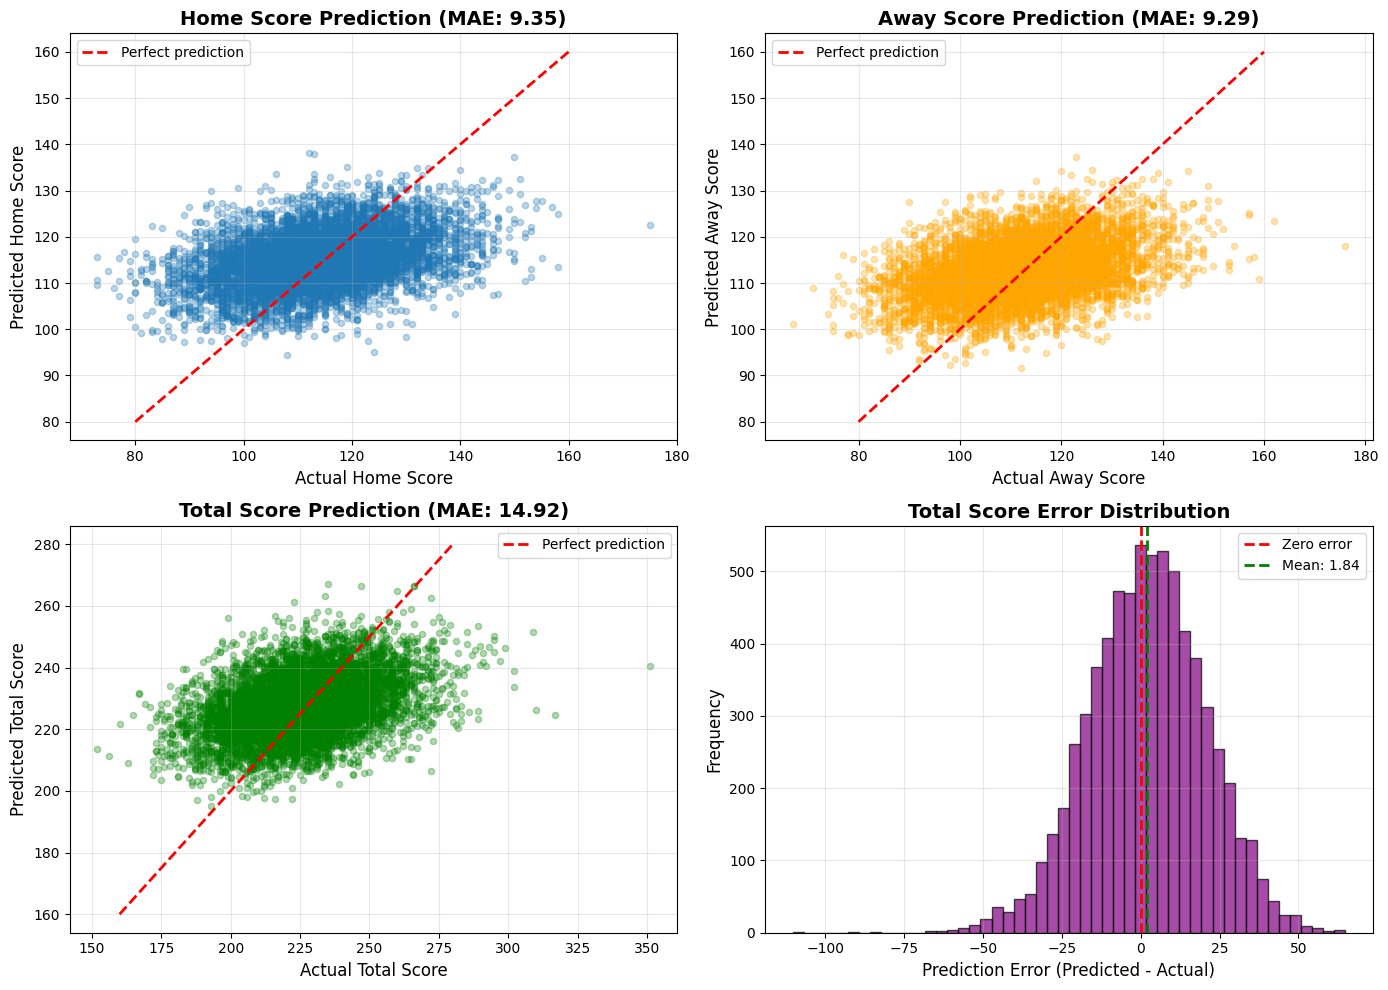

✅ Prediction visualizations complete


In [24]:
# ============================================================
# STEP 6: VISUALIZE PREDICTIONS
# ============================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Home Score Predictions
ax = axes[0, 0]
ax.scatter(actuals[:, 0], predictions[:, 0], alpha=0.3, s=20)
ax.plot([80, 160], [80, 160], 'r--', lw=2, label='Perfect prediction')
ax.set_xlabel('Actual Home Score', fontsize=12)
ax.set_ylabel('Predicted Home Score', fontsize=12)
ax.set_title(f'Home Score Prediction (MAE: {home_mae:.2f})', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Away Score Predictions
ax = axes[0, 1]
ax.scatter(actuals[:, 1], predictions[:, 1], alpha=0.3, s=20, color='orange')
ax.plot([80, 160], [80, 160], 'r--', lw=2, label='Perfect prediction')
ax.set_xlabel('Actual Away Score', fontsize=12)
ax.set_ylabel('Predicted Away Score', fontsize=12)
ax.set_title(f'Away Score Prediction (MAE: {away_mae:.2f})', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Total Score Predictions
ax = axes[1, 0]
ax.scatter(actuals[:, 2], predictions[:, 2], alpha=0.3, s=20, color='green')
ax.plot([160, 280], [160, 280], 'r--', lw=2, label='Perfect prediction')
ax.set_xlabel('Actual Total Score', fontsize=12)
ax.set_ylabel('Predicted Total Score', fontsize=12)
ax.set_title(f'Total Score Prediction (MAE: {total_mae:.2f})', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Error Distribution
ax = axes[1, 1]
total_errors = predictions[:, 2] - actuals[:, 2]
ax.hist(total_errors, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
ax.axvline(np.mean(total_errors), color='green', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(total_errors):.2f}')
ax.set_xlabel('Prediction Error (Predicted - Actual)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Total Score Error Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Prediction visualizations complete")

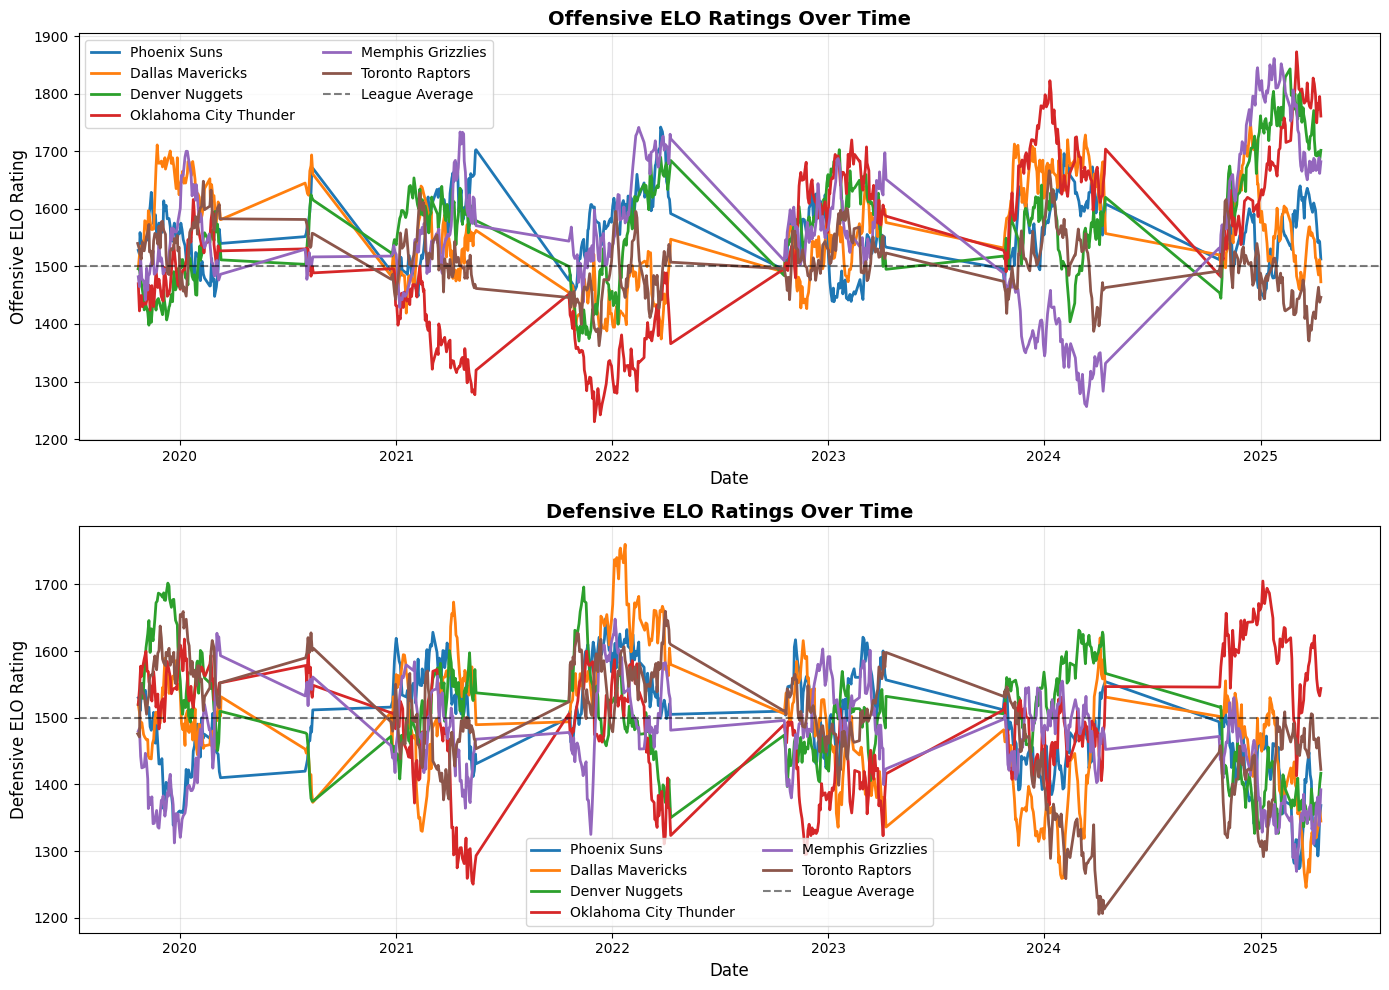

✅ ELO evolution visualizations complete


In [25]:
# ============================================================
# STEP 7: VISUALIZE ELO RATINGS OVER TIME
# ============================================================

# Convert history to DataFrame
history_df = pd.DataFrame(elo.history)

# Get a few interesting teams to plot
sample_teams = df_g['home_team_id'].value_counts().head(6).index.tolist()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Offensive ELO over time
ax = axes[0]
for team_id in sample_teams:
    team_name = df_g[df_g['home_team_id'] == team_id]['home_team'].iloc[0]
    
    # Get home games
    home_data = history_df[history_df['home_team'] == team_id][['date', 'home_off_elo']]
    home_data = home_data.rename(columns={'home_off_elo': 'off_elo'})
    
    # Get away games
    away_data = history_df[history_df['away_team'] == team_id][['date', 'away_off_elo']]
    away_data = away_data.rename(columns={'away_off_elo': 'off_elo'})
    
    # Combine
    team_data = pd.concat([home_data, away_data]).sort_values('date')
    
    ax.plot(team_data['date'], team_data['off_elo'], label=team_name, linewidth=2)

ax.axhline(1500, color='black', linestyle='--', alpha=0.5, label='League Average')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Offensive ELO Rating', fontsize=12)
ax.set_title('Offensive ELO Ratings Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='best', ncol=2)
ax.grid(True, alpha=0.3)

# Plot 2: Defensive ELO over time
ax = axes[1]
for team_id in sample_teams:
    team_name = df_g[df_g['home_team_id'] == team_id]['home_team'].iloc[0]
    
    # Get home games
    home_data = history_df[history_df['home_team'] == team_id][['date', 'home_def_elo']]
    home_data = home_data.rename(columns={'home_def_elo': 'def_elo'})
    
    # Get away games
    away_data = history_df[history_df['away_team'] == team_id][['date', 'away_def_elo']]
    away_data = away_data.rename(columns={'away_def_elo': 'def_elo'})
    
    # Combine
    team_data = pd.concat([home_data, away_data]).sort_values('date')
    
    ax.plot(team_data['date'], team_data['def_elo'], label=team_name, linewidth=2)

ax.axhline(1500, color='black', linestyle='--', alpha=0.5, label='League Average')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Defensive ELO Rating', fontsize=12)
ax.set_title('Defensive ELO Ratings Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='best', ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ ELO evolution visualizations complete")

In [26]:
# ============================================================
# STEP 8: CURRENT TEAM RANKINGS
# ============================================================

# Get current ratings for all teams
current_ratings = []

for team_id in df_g['home_team_id'].unique():
    team_name = df_g[df_g['home_team_id'] == team_id]['home_team'].iloc[0]
    season = df_g['home_season_id'].iloc[-1]
    
    off_elo = elo.get_offensive_rating(team_id, season)
    def_elo = elo.get_defensive_rating(team_id, season)
    
    current_ratings.append({
        'Team': team_name,
        'Offensive ELO': off_elo,
        'Defensive ELO': def_elo,
        'Overall ELO': (off_elo + def_elo) / 2
    })

ratings_df = pd.DataFrame(current_ratings).sort_values('Overall ELO', ascending=False)

print("\n" + "="*60)
print("🏆 CURRENT TEAM RANKINGS (by Overall ELO)")
print("="*60)
print(ratings_df.to_string(index=False))
print("="*60)


🏆 CURRENT TEAM RANKINGS (by Overall ELO)
                  Team  Offensive ELO  Defensive ELO  Overall ELO
 Oklahoma City Thunder    1761.426413    1543.952450  1652.689431
           LA Clippers    1660.528866    1610.649459  1635.589162
 Golden State Warriors    1581.668868    1606.160611  1593.914739
        Boston Celtics    1518.369767    1664.051194  1591.210481
Minnesota Timberwolves    1629.868902    1537.102481  1583.485691
   Cleveland Cavaliers    1693.469456    1461.597380  1577.533418
        Denver Nuggets    1701.867756    1416.741831  1559.304793
       Milwaukee Bucks    1689.312172    1424.189792  1556.750982
        Indiana Pacers    1682.733667    1428.193089  1555.463378
    Los Angeles Lakers    1582.217672    1523.014664  1552.616168
       Houston Rockets    1616.348732    1482.420662  1549.384697
         Chicago Bulls    1717.788497    1372.239899  1545.014198
         Orlando Magic    1363.354260    1722.750860  1543.052560
            Miami Heat    1514.056

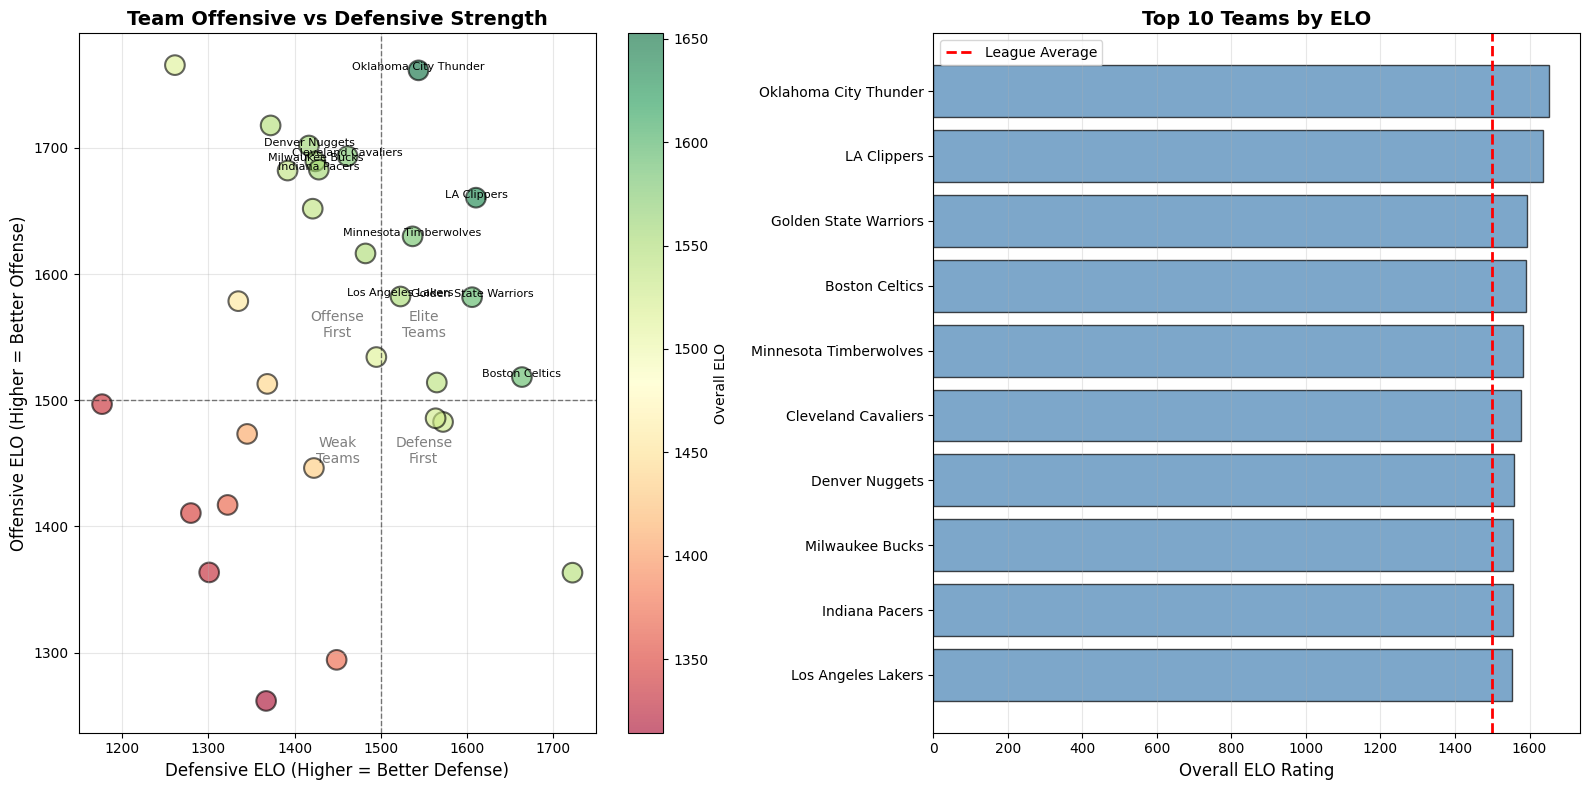

✅ Team rankings visualizations complete


In [27]:
# ============================================================
# STEP 9: VISUALIZE TEAM RANKINGS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Offensive vs Defensive ELO
ax = axes[0]
scatter = ax.scatter(
    ratings_df['Defensive ELO'], 
    ratings_df['Offensive ELO'],
    s=200, 
    alpha=0.6,
    c=ratings_df['Overall ELO'],
    cmap='RdYlGn',
    edgecolors='black',
    linewidth=1.5
)

# Add team labels
for _, row in ratings_df.head(10).iterrows():  # Label top 10
    ax.annotate(
        row['Team'], 
        (row['Defensive ELO'], row['Offensive ELO']),
        fontsize=8,
        ha='center'
    )

ax.axhline(1500, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(1500, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax.set_xlabel('Defensive ELO (Higher = Better Defense)', fontsize=12)
ax.set_ylabel('Offensive ELO (Higher = Better Offense)', fontsize=12)
ax.set_title('Team Offensive vs Defensive Strength', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add quadrant labels
ax.text(1550, 1550, 'Elite\nTeams', fontsize=10, ha='center', alpha=0.5)
ax.text(1450, 1450, 'Weak\nTeams', fontsize=10, ha='center', alpha=0.5)
ax.text(1550, 1450, 'Defense\nFirst', fontsize=10, ha='center', alpha=0.5)
ax.text(1450, 1550, 'Offense\nFirst', fontsize=10, ha='center', alpha=0.5)

plt.colorbar(scatter, ax=ax, label='Overall ELO')

# Plot 2: Top 10 teams bar chart
ax = axes[1]
top_10 = ratings_df.head(10).sort_values('Overall ELO')
y_pos = np.arange(len(top_10))

ax.barh(y_pos, top_10['Overall ELO'], alpha=0.7, color='steelblue', edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_10['Team'])
ax.set_xlabel('Overall ELO Rating', fontsize=12)
ax.set_title('Top 10 Teams by ELO', fontsize=14, fontweight='bold')
ax.axvline(1500, color='red', linestyle='--', linewidth=2, label='League Average')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("✅ Team rankings visualizations complete")

In [28]:
# ============================================================
# STEP 10: EXAMPLE PREDICTION FOR UPCOMING GAME
# ============================================================

print("\n" + "="*60)
print("🎯 EXAMPLE: PREDICT AN UPCOMING GAME")
print("="*60)

# Pick two teams
example_home = ratings_df.iloc[0]['Team']  # Best team
example_away = ratings_df.iloc[5]['Team']  # Middle team

# Get their IDs
home_id = df_g[df_g['home_team'] == example_home]['home_team_id'].iloc[0]
away_id = df_g[df_g['away_team'] == example_away]['away_team_id'].iloc[0]
season = df_g['home_season_id'].iloc[-1]

# Make prediction
pred = elo.predict(home_id, away_id, season)

print(f"\n🏀 Matchup: {example_away} @ {example_home}")
print(f"\n📊 Team Ratings:")
print(f"   {example_home}:")
print(f"      Offensive ELO: {pred['home_off_elo']:.0f}")
print(f"      Defensive ELO: {pred['home_def_elo']:.0f}")
print(f"   {example_away}:")
print(f"      Offensive ELO: {pred['away_off_elo']:.0f}")
print(f"      Defensive ELO: {pred['away_def_elo']:.0f}")

print(f"\n🎯 Prediction:")
print(f"   {example_home}: {pred['home_score']:.1f} points")
print(f"   {example_away}: {pred['away_score']:.1f} points")
print(f"   Total: {pred['total_score']:.1f} points")
print(f"   Spread: {example_home} by {pred['home_score'] - pred['away_score']:.1f}")
print("="*60)


🎯 EXAMPLE: PREDICT AN UPCOMING GAME

🏀 Matchup: Cleveland Cavaliers @ Oklahoma City Thunder

📊 Team Ratings:
   Oklahoma City Thunder:
      Offensive ELO: 1761
      Defensive ELO: 1544
   Cleveland Cavaliers:
      Offensive ELO: 1693
      Defensive ELO: 1462

🎯 Prediction:
   Oklahoma City Thunder: 124.5 points
   Cleveland Cavaliers: 116.0 points
   Total: 240.5 points
   Spread: Oklahoma City Thunder by 8.5
